[I 2025-04-20 09:24:03,560] A new study created in memory with name: no-name-f8b7e1fa-9785-4261-be4f-5037d2252361


🔍 Starting hyperparameter tuning with Optuna...


[I 2025-04-20 09:24:05,822] Trial 0 finished with value: 0.8814884424209595 and parameters: {'n_estimators': 243, 'max_depth': 6, 'learning_rate': 0.1471331359207198, 'subsample': 0.7200882296842771, 'colsample_bytree': 0.9280045437833012, 'gamma': 1.0753224051677086, 'min_child_weight': 6}. Best is trial 0 with value: 0.8814884424209595.
[I 2025-04-20 09:24:06,166] Trial 1 finished with value: 1.0170526504516602 and parameters: {'n_estimators': 728, 'max_depth': 6, 'learning_rate': 0.22818527496942373, 'subsample': 0.7683760936139831, 'colsample_bytree': 0.5405711498872672, 'gamma': 0.7999140349768391, 'min_child_weight': 1}. Best is trial 0 with value: 0.8814884424209595.
[I 2025-04-20 09:24:06,287] Trial 2 finished with value: 1.0155003070831299 and parameters: {'n_estimators': 230, 'max_depth': 6, 'learning_rate': 0.2654761603891259, 'subsample': 0.9566219648258468, 'colsample_bytree': 0.7236288169388565, 'gamma': 3.333070051768811, 'min_child_weight': 4}. Best is trial 0 with valu

✅ Best Parameters Found:
  n_estimators: 536
  max_depth: 7
  learning_rate: 0.029043282109981472
  subsample: 0.8342089822157398
  colsample_bytree: 0.961340434845555
  gamma: 1.9788078805122125
  min_child_weight: 3

📏 Final Mean Absolute Error: 0.83


<Figure size 1200x600 with 0 Axes>

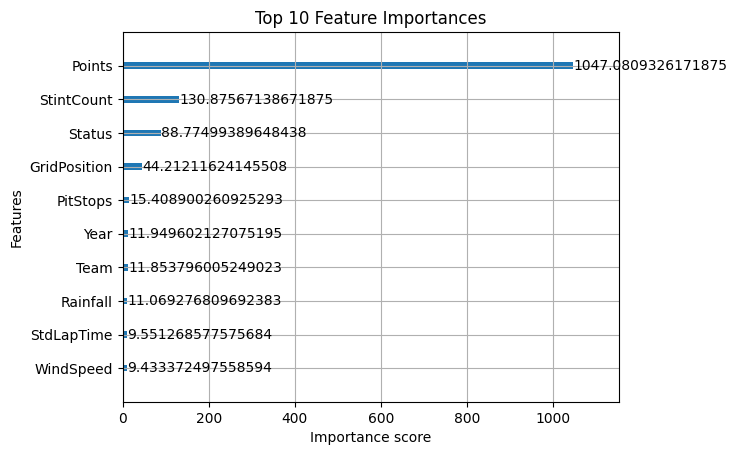


🔍 Input Features for Prediction (Human-readable):
Year: 2018.0
Round: 10.0
GrandPrix: British Grand Prix
Country: Great Britain
Driver: MAG
Team: Haas F1 Team
GridPosition: 7.0
Points: 2.0
Status: Finished
MeanLapTime: 101.5956154
StdLapTime: 14.4888409
PitStops: 1.0
FirstCompound: nan
StintCount: 2.0
AirTemp: 27.43163265
Rainfall: 0.0
Humidity: 38.73979592
WindSpeed: 1.46122449
TrackTemp: 52.16938776

🏁 Predicted Finishing Position: 9


In [2]:
import pandas as pd
import numpy as np
import pickle
import random
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from xgboost import plot_importance

# === 1. Load and encode data ===
df = pd.read_csv("f1_2018-2024_Model_data.csv")

encoders = {}
categorical_cols = ['Driver', 'Team', 'GrandPrix', 'Country', 'Status', 'FirstCompound']

for col in categorical_cols:
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col])
    encoders[col] = enc

with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

X = df.drop(columns=['Position'])
y = df['Position']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 2. Define Optuna optimization ===
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42
    }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

# === 3. Run Optuna ===
print("🔍 Starting hyperparameter tuning with Optuna...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

best_params = study.best_params
print("✅ Best Parameters Found:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# === 4. Train with best parameters ===
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# === 5. Evaluate Model ===
preds = final_model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"\n📏 Final Mean Absolute Error: {mae:.2f}")

# === 6. Feature Importance ===
plt.figure(figsize=(12, 6))
plot_importance(final_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances")
plt.show()

# === 7. Predict Random Sample with Real Names ===
with open('label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

sample = X_test.sample(1, random_state=random.randint(0, 10000))
sample_input = sample.values.reshape(1, -1)

print("\n🔍 Input Features for Prediction (Human-readable):")
for col, val in zip(X.columns, sample.iloc[0]):
    if col in encoders:
        decoded_val = encoders[col].inverse_transform([int(val)])[0]
        print(f"{col}: {decoded_val}")
    else:
        print(f"{col}: {val}")

predicted_position = final_model.predict(sample_input)[0]
print(f"\n🏁 Predicted Finishing Position: {round(predicted_position)}")


In [11]:
# Save the trained model as a JSON file
final_model.save_model("xgb_f1_model.json")
